In [3]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = Path("/content/drive/MyDrive/UTKFace/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [5]:
print(len(filenames))
print(filenames[:3])

23706
['55_0_3_20170119201009922.jpg.chip.jpg', '55_0_3_20170119201108715.jpg.chip.jpg', '55_0_3_20170119201235270.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [6]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [7]:
image_path

['26_0_1_20170116214531552.jpg.chip.jpg',
 '50_0_0_20170117185149577.jpg.chip.jpg',
 '24_1_2_20170116162430984.jpg.chip.jpg',
 '57_0_0_20170111171747481.jpg.chip.jpg',
 '32_1_1_20170113000615118.jpg.chip.jpg',
 '27_0_1_20170117012811248.jpg.chip.jpg',
 '26_0_1_20170113174249954.jpg.chip.jpg',
 '28_0_0_20170116211700944.jpg.chip.jpg',
 '1_0_3_20161220220038618.jpg.chip.jpg',
 '39_0_0_20170116222959772.jpg.chip.jpg',
 '28_1_0_20170103182323771.jpg.chip.jpg',
 '57_0_0_20170117172537601.jpg.chip.jpg',
 '26_1_3_20170119192422098.jpg.chip.jpg',
 '1_0_2_20161220144914327.jpg.chip.jpg',
 '36_1_1_20170116161213859.jpg.chip.jpg',
 '45_0_3_20170120221319813.jpg.chip.jpg',
 '1_1_2_20161219200309555.jpg.chip.jpg',
 '3_1_4_20161221192709141.jpg.chip.jpg',
 '30_1_2_20170104192931704.jpg.chip.jpg',
 '52_1_0_20170104212301653.jpg.chip.jpg',
 '27_1_2_20170116162015711.jpg.chip.jpg',
 '21_0_4_20161223214821265.jpg.chip.jpg',
 '46_1_0_20170110151342799.jpg.chip.jpg',
 '8_1_0_20170109202926726.jpg.chip.jpg

# From Unstructured data to Structured data

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [9]:
df.head()

,image,age,gender
0,26_0_1_20170116214531552.jpg.chip.jpg,26,0
1,50_0_0_20170117185149577.jpg.chip.jpg,50,0
2,24_1_2_20170116162430984.jpg.chip.jpg,24,1
3,57_0_0_20170111171747481.jpg.chip.jpg,57,0
4,32_1_1_20170113000615118.jpg.chip.jpg,32,1


In [10]:
gender_dict = {0:"Male",1:"Female"}

In [11]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [12]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


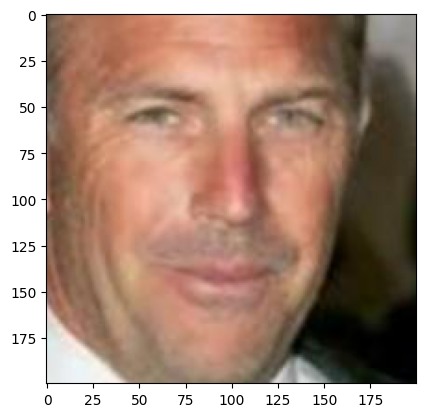

In [31]:
img = Image.open('/content/drive/MyDrive/UTKFace/UTKFace/'+df.image[1])
plt.imshow(img)

<ipython-input-32-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

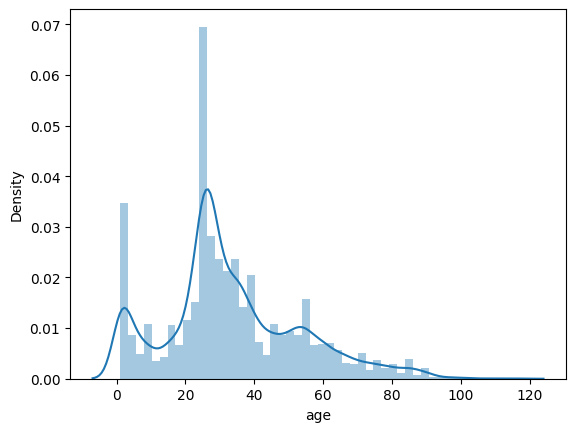

In [32]:
sns.distplot(df.age)

# Plotting Images

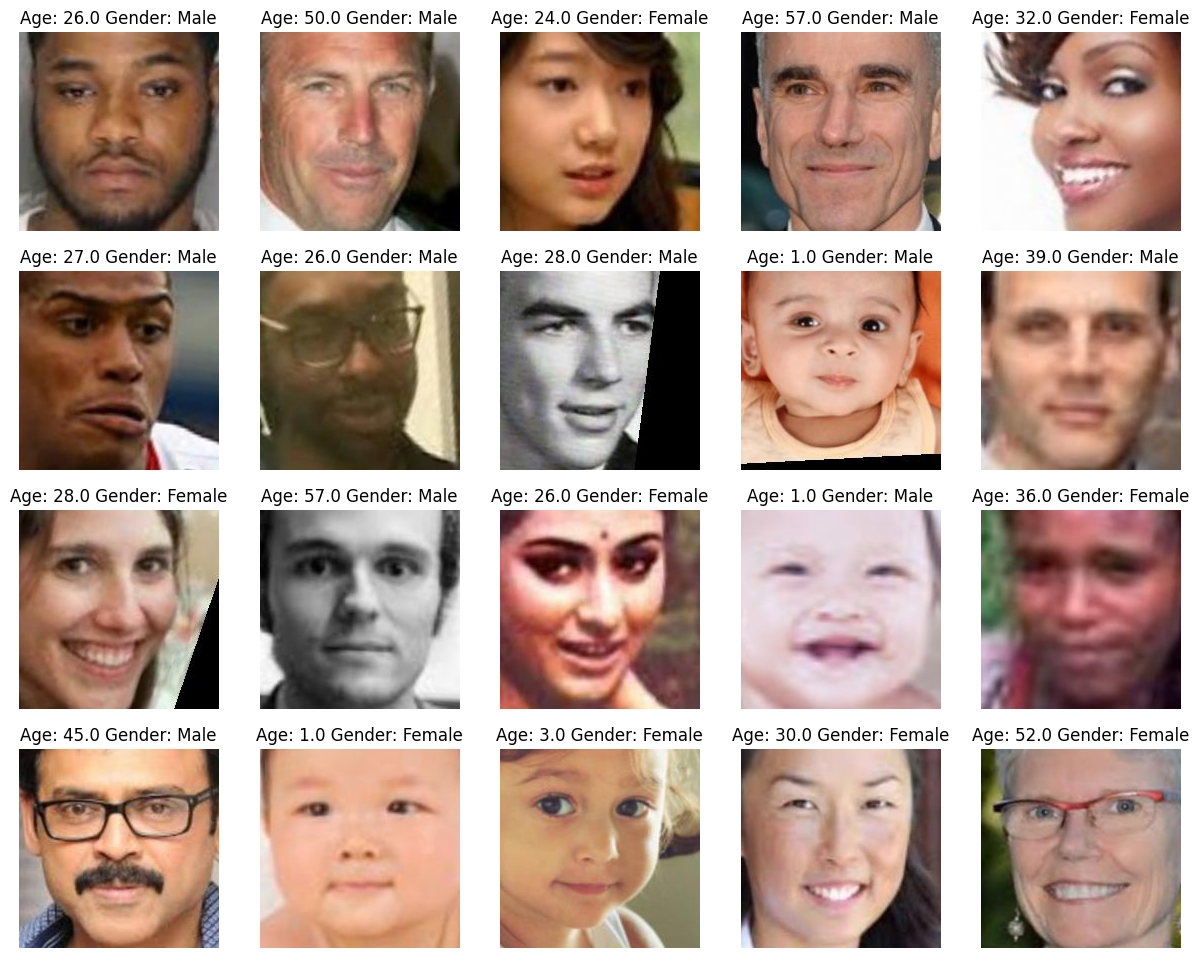

In [34]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/drive/MyDrive/UTKFace/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [35]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [36]:
train.head()

,image,age,gender
18199,26_0_0_20170117172630031.jpg.chip.jpg,26.0,0
19557,25_0_1_20170113151512351.jpg.chip.jpg,25.0,0
20132,26_1_3_20170117154607967.jpg.chip.jpg,26.0,1
11849,28_1_1_20170113002039715.jpg.chip.jpg,28.0,1
2100,54_0_0_20170104205516571.jpg.chip.jpg,54.0,0


# Extracting Features

In [37]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/content/drive/MyDrive/UTKFace/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [38]:
x_train.shape

(3555, 128, 128, 1)

# Normalizing data

In [39]:
x_train = x_train/255

In [40]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [41]:
input_size = (128,128,1)

# Creating model

In [42]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
SIZE=128
N_ch=1
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output_1 = Dense(1,activation='sigmoid', name='gender_output')(x)
    output_2 = Dense(1, activation='relu', name='age_output')(x) 

    # model
    model = Model(input, outputs=[output_1,output_2])
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss=['binary_crossentropy','mae'], optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

# Training the model

In [43]:
model = build_densenet()
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  30          ['input_2[0][0]']                
                                                                                                  
 densenet121 (Functional)       (None, None, None,   7037504     ['conv2d[0][0]']                 
                                1024)                                                             
                             

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 7,305,568
Trainable params: 7,219,360
Non-trainable params: 86,208
__________________________________________________________________________________________________
Epoch 1/20
320/320 [==============================] - 959s 3s/step - loss: 25.0194 - gender_output_loss: 0.8348 - age_output_loss: 24.1846 - gender_output_accuracy: 0.5861 - age_output_accuracy: 0.0153 - val_loss: 40.3276 - val_gender_output_loss: 8.2805 - val_age_output_loss: 32.0471 - val_gender_output_accuracy: 0.5028 - val_age_output_accuracy: 0.0056
Epoch 2/20
320/320 [==============================] - 905s 3s/step - loss: 17.9008 - gender_output_loss: 0.8055 - age_output_loss: 17.0953 - gender_output_accuracy: 0.5361 - age_output_accuracy: 0.0325 - val_loss: 17.1158 - val_gender_output_loss: 0.6763 - val_age_output_loss: 16.4394 - val_gender_output_accuracy: 0.5815 - val_age_output_accuracy: 0.0449
Epoch 3/20
320/320 [==============================] - 904s 3s/step - loss: 16.5817 - gender_output_loss: 0

# Visualizing loss

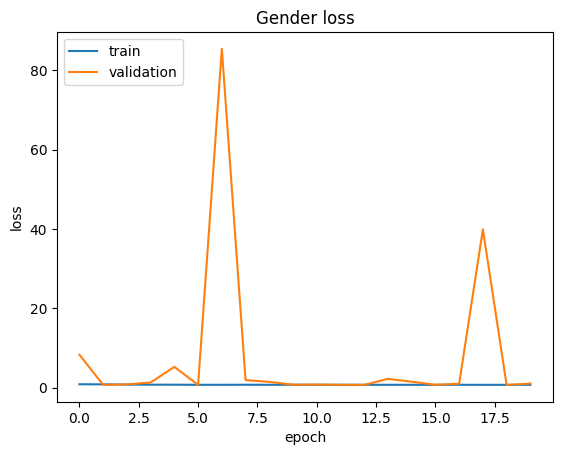

In [44]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

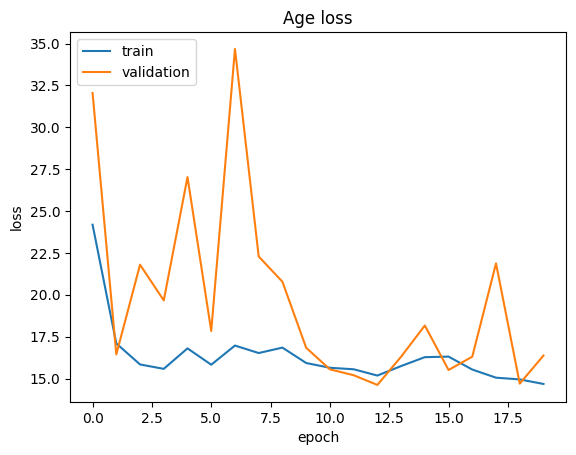

In [45]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Female  Age =  2.0
1/1 [==============================] - 0s 167ms/step
Prediction: Gender =  Female  Age =  22


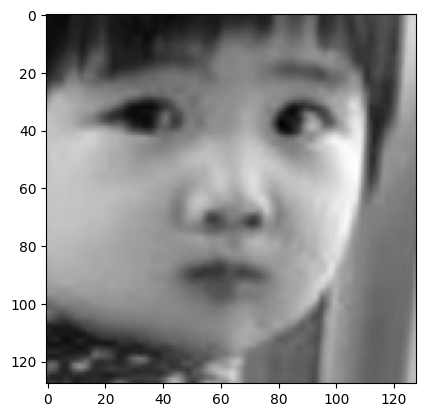

In [49]:
index=53
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

Original: Gender =  Male  Age =  30.0
1/1 [==============================] - 0s 225ms/step
Prediction: Gender =  Male  Age =  31


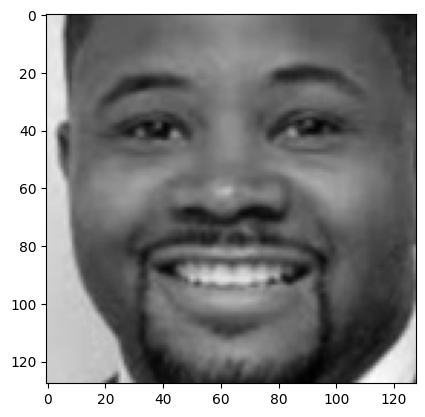

In [51]:
index=29
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')